<a href="https://colab.research.google.com/github/VinayaSharada/handson-ml3/blob/main/Finance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install mesa

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.0/197.0 kB 7.5 MB/s eta 0:00:00


In [2]:
!pip install solara

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 93.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.8/265.8 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.8/454.8 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 68.6 MB/s eta 0:00:00


In [3]:
from mesa.discrete_space import CellAgent


class MoneyAgent(CellAgent):
    """An agent with fixed initial wealth.

    Each agent starts with 1 unit of wealth and can give 1 unit to other agents
    if they occupy the same cell.

    Attributes:
        wealth (int): The agent's current wealth (starts at 1)
    """

    def __init__(self, model, cell):
        """Create a new agent.

        Args:
            model (Model): The model instance that contains the agent
        """
        super().__init__(model)
        self.cell = cell
        self.wealth = 1

    def move(self):
        """Move the agent to a random neighboring cell."""
        self.cell = self.cell.neighborhood.select_random_cell()

    def give_money(self):
        """Give 1 unit of wealth to a random agent in the same cell."""
        cellmates = [a for a in self.cell.agents if a is not self]

        if cellmates:  # Only give money if there are other agents present
            other = self.random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        """Execute one step for the agent:
        1. Move to a neighboring cell
        2. If wealth > 0, maybe give money to another agent in the same cell
        """
        self.move()
        if self.wealth > 0:
            self.give_money()


In [4]:
"""
Boltzmann Wealth Model
=====================

A simple model of wealth distribution based on the Boltzmann-Gibbs distribution.
Agents move randomly on a grid, giving one unit of wealth to a random neighbor
when they occupy the same cell.
"""

from mesa import Model
from mesa.datacollection import DataCollector
from mesa.discrete_space import OrthogonalMooreGrid
from mesa.examples.basic.boltzmann_wealth_model.agents import MoneyAgent


class BoltzmannWealth(Model):
    """A simple model of an economy where agents exchange currency at random.

    All agents begin with one unit of currency, and each time step agents can give
    a unit of currency to another agent in the same cell. Over time, this produces
    a highly skewed distribution of wealth.

    Attributes:
        num_agents (int): Number of agents in the model
        grid (MultiGrid): The space in which agents move
        running (bool): Whether the model should continue running
        datacollector (DataCollector): Collects and stores model data
    """

    def __init__(self, n=100, width=10, height=10, seed=None):
        """Initialize the model.

        Args:
            n (int, optional): Number of agents. Defaults to 100.
            width (int, optional): Grid width. Defaults to 10.
            height (int, optional): Grid height. Defaults to 10.
            seed (int, optional): Random seed. Defaults to None.
        """
        super().__init__(seed=seed)

        self.num_agents = n
        self.grid = OrthogonalMooreGrid((width, height), random=self.random)

        # Set up data collection
        self.datacollector = DataCollector(
            model_reporters={"Gini": self.compute_gini},
            agent_reporters={"Wealth": "wealth"},
        )
        MoneyAgent.create_agents(
            self,
            self.num_agents,
            self.random.choices(self.grid.all_cells.cells, k=self.num_agents),
        )

        self.running = True
        self.datacollector.collect(self)

    def step(self):
        self.agents.shuffle_do("step")  # Activate all agents in random order
        self.datacollector.collect(self)  # Collect data

    def compute_gini(self):
        """Calculate the Gini coefficient for the model's current wealth distribution.

        The Gini coefficient is a measure of inequality in distributions.
        - A Gini of 0 represents complete equality, where all agents have equal wealth.
        - A Gini of 1 represents maximal inequality, where one agent has all wealth.
        """
        agent_wealths = [agent.wealth for agent in self.agents]
        x = sorted(agent_wealths)
        n = self.num_agents
        # Calculate using the standard formula for Gini coefficient
        b = sum(xi * (n - i) for i, xi in enumerate(x)) / (n * sum(x))
        return 1 + (1 / n) - 2 * b

In [5]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Initialize and run the model
model = BoltzmannWealth(n=50, width=10, height=10, seed=42)

# Helper to map GridCell object to its (x, y) position
cell_pos_map = {
    cell: (x, y)
    for x in range(model.grid.width)
    for y in range(model.grid.height)
    for cell in [model.grid[x, y]]
}

# Run and collect data
steps = 100
positions_over_time = []
wealths_over_time = []
gini_over_time = []

for _ in range(steps):
    model.step()
    pos = [cell_pos_map[agent.cell] for agent in model.agents]
    wealth = [agent.wealth for agent in model.agents]
    positions_over_time.append(pos)
    wealths_over_time.append(wealth)
    gini_over_time.append(model.compute_gini())

# Plot setup
fig, ax = plt.subplots(figsize=(6, 6))

def update(frame):
    ax.clear()
    ax.set_xlim(0, model.grid.width)
    ax.set_ylim(0, model.grid.height)
    ax.set_title(f"Step {frame} | Gini: {gini_over_time[frame]:.3f}")
    x, y = zip(*positions_over_time[frame])
    c = wealths_over_time[frame]
    sc = ax.scatter(x, y, c=c, cmap='viridis', s=100, edgecolor='black')
    return sc,

ani = animation.FuncAnimation(fig, update, frames=steps, interval=300, blit=False)
plt.close()

# Display animation in Colab
HTML(ani.to_jshtml())


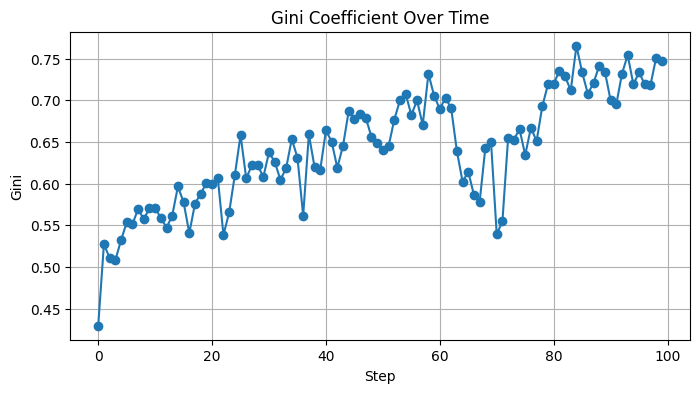

In [6]:
plt.figure(figsize=(8, 4))
plt.plot(gini_over_time, marker='o')
plt.title("Gini Coefficient Over Time")
plt.xlabel("Step")
plt.ylabel("Gini")
plt.grid(True)
plt.show()


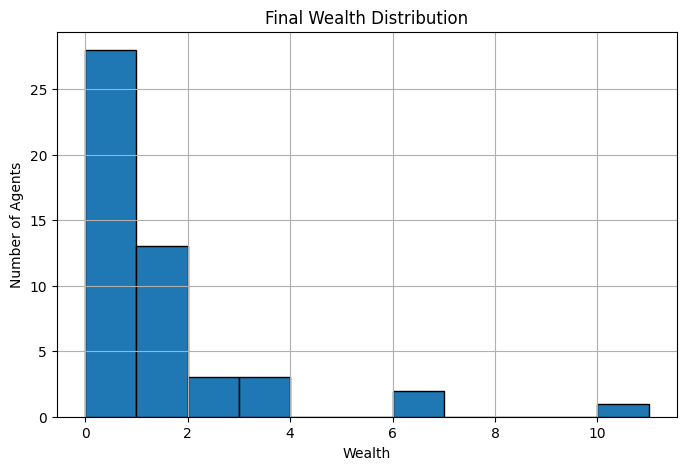

In [7]:
import matplotlib.pyplot as plt

# Get final wealth of all agents
final_wealth = [agent.wealth for agent in model.agents]

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(final_wealth, bins=range(min(final_wealth), max(final_wealth)+2), edgecolor='black')
plt.title("Final Wealth Distribution")
plt.xlabel("Wealth")
plt.ylabel("Number of Agents")
plt.grid(True)
plt.show()
